# Pyramidal Lucas-Kanade Optical Flow Project
$by$

$Mostafa$ $Hazem$&nbsp;&nbsp;&nbsp;&nbsp;$2205174$

$Khaled$ $Walid$ $Ghalwash$&nbsp;&nbsp;&nbsp;&nbsp;$2205018$

### Data Set Visualization

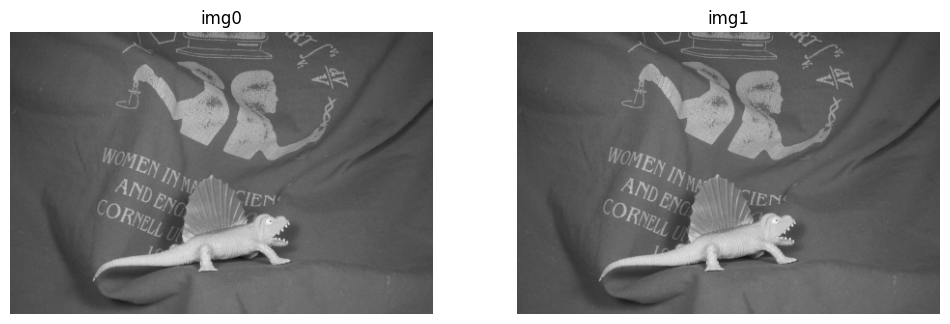

In [12]:
import matplotlib.pyplot as plt
import cv2


img0 = cv2.imread('im0.png')
img1 = cv2.imread('im1.png')


img0_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# == Visualization ===
axes[0].imshow(img0_rgb)
axes[0].set_title('img0')
axes[0].axis('off')

axes[1].imshow(img1_rgb)
axes[1].set_title('img1')
axes[1].axis('off')

# Show the plot
plt.show()

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### The Sobel operator
computes the image gradients in the x and y directions using the convolution of the image with two kernels. The horizontal Sobel kernel $G_x$ is given by:

$
G_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}
$

and the vertical Sobel kernel $G_y$ is:

$
G_y = \begin{pmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{pmatrix}
$

The gradients are computed by convolving the image $I(i, j)$ with the kernels, where:

$
S_x(i, j) = \sum_{m=-1}^{1} \sum_{n=-1}^{1} G_x(m, n) \cdot I(i+m, j+n)
$

and

$
S_y(i, j) = \sum_{m=-1}^{1} \sum_{n=-1}^{1} G_y(m, n) \cdot I(i+m, j+n)
$

These give the gradients in the x-direction $I_x$ and y-direction $I_y$. The magnitude of the gradient is computed as:

$
\text{Magnitude} = \sqrt{I_x^2 + I_y^2}
$

indicating edge strength, while the direction of the gradient is:

$
\text{Direction} = \arctan\left(\frac{I_y}{I_x}\right)
$

representing edge orientation. These gradients provide crucial information about edges and structure in the image.


In [14]:
def compute_gradients(img):
    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)  # Positive Ix = intensity increases rightward
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)  # Positive Iy = intensity increases downward
    return Ix, Iy

#### The function `warp_image(img, u, v)`
 performs image warping by shifting the image according to displacement vectors $u$ and $v$. First, the height $h$ and width $w$ of the image are obtained. Then, a meshgrid is created with the coordinates of the image using `np.meshgrid`, where `grid_x` and `grid_y` represent the x and y coordinates of each pixel. The displacement vectors $u$ and $v$ are added to the respective coordinates, giving the new coordinates:

$$
\text{map}_x = (\text{grid}_x + u)
$$

and

$$
\text{map}_y = (\text{grid}_y + v)
$$

These new coordinates are then used in the function `cv2.remap`, which maps the image pixels to their new locations. The remapping uses linear interpolation with border reflection (`cv2.BORDER_REFLECT`) to handle pixels at the image boundaries.

In [15]:
def warp_image(img, u, v):
    h, w = img.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + u).astype(np.float32)  # Positive u shifts I2_l rightward to match I1_l
    map_y = (grid_y + v).astype(np.float32)  # Positive v shifts I2_l downward
    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

#### The function `build_pyramid(img, levels)`
creates an image pyramid, which is a series of images with progressively lower resolutions. The function starts by initializing the pyramid with the original image. Then, for each level from 1 to `levels-1`, the image is downsampled using the `cv2.pyrDown` function, which reduces the image size by a factor of 2. Each downsampled image is appended to the pyramid list:

$$
\text{pyramid} = [\text{img}]
$$

For each subsequent level, the image is downsampled:

$$
\text{img} = \text{cv2.pyrDown(img)}
$$

After all levels are generated, the pyramid is reversed to return the images from the smallest to the largest resolution. The final pyramid is:

$$
\text{pyramid[::-1]}
$$


In [16]:
def build_pyramid(img, levels):
    pyramid = [img]
    for _ in range(1, levels):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid[::-1]

#### The function `pyramidal_lucas_kanade(I1, I2, levels=4, window_size=15, iterations=3, eigen_thresh=1e-4)`
implements the Lucas-Kanade optical flow method using a pyramidal approach. The function starts by checking that the input images $I_1$ and $I_2$ have the same shape, are grayscale, and that the `window_size` is odd. It also checks that the pyramid level is not too small for the chosen window size. The images are normalized by dividing them by 255:

$$
I_1 = \frac{I_1}{255.0}, \quad I_2 = \frac{I_2}{255.0}
$$

Next, image pyramids for both images are generated using the `build_pyramid` function. The initial optical flow is set to zero:

$$
u = v = 0
$$

For each pyramid level, the flow is refined using the Lucas-Kanade method. The optical flow is upsampled from the previous level using `cv2.pyrUp`, and resized to the current level's dimensions. The gradients $I_x$ and $I_y$ are computed using the `compute_gradients` function, and the flow is updated using the equation:

$$
A = \begin{pmatrix} I_x & I_y \end{pmatrix}, \quad b = -I_t
$$

where $I_t$ is the temporal difference between the warped image and the original image at the current level. The least squares solution is computed using:

$$
\mathbf{A}^T \mathbf{A} \nu = \mathbf{A}^T \mathbf{b}
$$

where $\nu = \begin{pmatrix} u \\ v \end{pmatrix}$ is the optical flow at the pixel. The flow is updated at each pixel, and the process is repeated for each level of the pyramid. The final flow vectors $u$ and $v$ are returned.


In [17]:
def pyramidal_lucas_kanade(I1, I2, levels=4, window_size=15, iterations=3, eigen_thresh=1e-4):
    if I1.shape != I2.shape:
        raise ValueError("Input images must have the same shape")
    if len(I1.shape) != 2:
        raise ValueError("Input images must be grayscale")
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")
    min_size = min(I1.shape) / (2 ** (levels - 1))
    if min_size < window_size:
        raise ValueError("Pyramid level too small for window_size")

    I1 = I1.astype(np.float32) / 255.0
    I2 = I2.astype(np.float32) / 255.0

    pyr1 = build_pyramid(I1, levels)
    pyr2 = build_pyramid(I2, levels)

    u = np.zeros_like(pyr1[0])
    v = np.zeros_like(pyr1[0])

    hw = window_size // 2

    for level in range(levels):
        I1_l = pyr1[level]
        I2_l = pyr2[level]

        if level != 0:
            u = cv2.pyrUp(u) * 2
            v = cv2.pyrUp(v) * 2
            h, w = I1_l.shape
            u = cv2.resize(u, (w, h), interpolation=cv2.INTER_LINEAR)
            v = cv2.resize(v, (w, h), interpolation=cv2.INTER_LINEAR)

        Ix, Iy = compute_gradients(I1_l)

        for _ in range(iterations):
            I2_warped = warp_image(I2_l, u, v)
            It = I2_warped - I1_l  # Follow pseudocode

            for y in range(hw, I1_l.shape[0] - hw):
                for x in range(hw, I1_l.shape[1] - hw):
                    Ix_win = Ix[y - hw:y + hw + 1, x - hw:x + hw + 1].flatten()
                    Iy_win = Iy[y - hw:y + hw + 1, x - hw:x + hw + 1].flatten()
                    It_win = It[y - hw:y + hw + 1, x - hw:x + hw + 1].flatten()

                    A = np.vstack((Ix_win, Iy_win)).T
                    b = -It_win.reshape(-1, 1)

                    ATA = A.T @ A
                    if np.min(np.linalg.eigvals(ATA)) < eigen_thresh:
                        continue

                    try:
                        nu = np.linalg.lstsq(A, b, rcond=None)[0]
                        u[y, x] += nu[0, 0]
                        v[y, x] += nu[1, 0]
                    except np.linalg.LinAlgError:
                        continue

    return u, v

#### Visualization

In [18]:
# === Visualization ===

def draw_quiver(u, v, step=10, title="Optical Flow", scale=5, exaggeration_factor=50):
    h, w = u.shape
    y, x = np.mgrid[0:h:step, 0:w:step]
    u_s = u[::step, ::step] * exaggeration_factor  # Apply exaggeration factor
    v_s = v[::step, ::step] * exaggeration_factor  # Apply exaggeration factor

    magnitude = np.sqrt(u_s**2 + v_s**2)

    plt.figure(figsize=(12, 8))
    plt.quiver(x, y, u_s, -v_s, magnitude, angles='xy', scale_units='xy', scale=scale, cmap='jet')
    plt.colorbar(label="Flow Magnitude")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

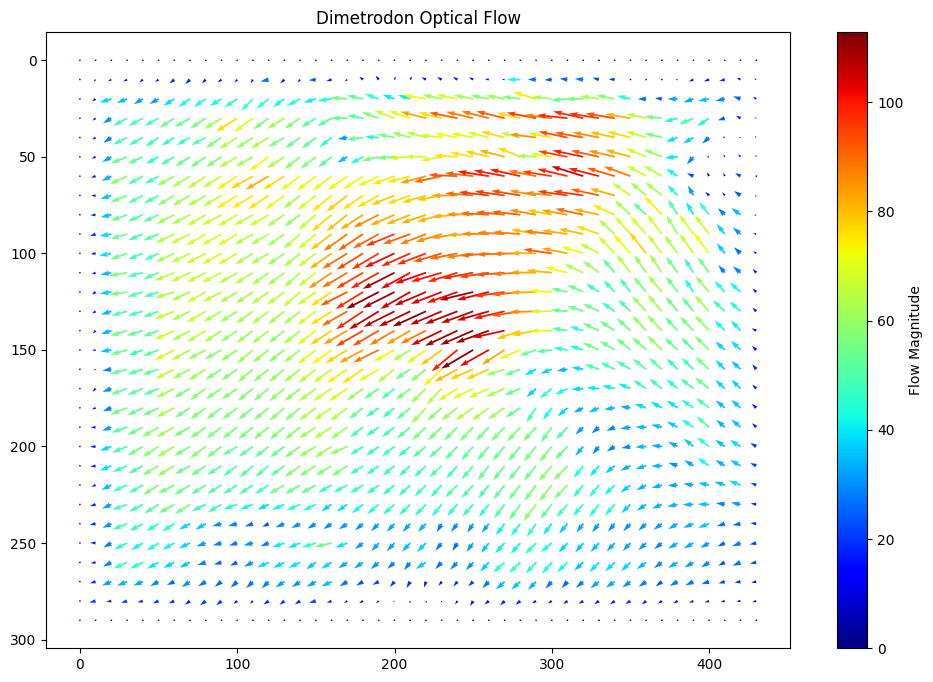

In [20]:
# === Main Script ===

if __name__ == "__main__":
    # Load the images from Dimetrodon dataset
    I1 = cv2.imread('/content/im0.png', cv2.IMREAD_GRAYSCALE)
    I2 = cv2.imread('/content/im1.png', cv2.IMREAD_GRAYSCALE)

    # Safety check
    if I1 is None or I2 is None:
        raise FileNotFoundError("One or both input images could not be loaded.")

    # Run pyramidal Lucas-Kanade
    u, v = pyramidal_lucas_kanade(I1, I2, levels=4, window_size=15, iterations=3)

    # Visualize the optical flow using quiver plot with exaggerated flow
    draw_quiver(u, v, step=10, title="Dimetrodon Optical Flow", exaggeration_factor=50)